# DESI MWS SV DESIGN

* Defines a set of tiles for a MWS SV plan.
* Defines MWS SV target classes with a custom YAML file.
* Patches `desistarget.cuts` with custom functions implementing MWS SV.
* Selects targets from sweeps using `desitarget.cuts.select_targets`.

In [1]:
RUN_NAME = 'tutorial'

In [2]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# SV planning object classes
import apcsv.plan
reload(apcsv.plan)
from apcsv.plan import Tile, Dither

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))



Wed Jan 16 01:53:42 PST 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.27.0.dev2786      
desimodel       0.9.9.dev464        
fiberassign     0.11.0.dev2265

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan [16 entries exceeds filelimit, not opening dir]

Files under the run directory:
Wed Jan 16 01:53:43 PST 2019
/global/u1/a/apcooper/projects/mws_svplan/runs/tutorial/run
├── [Jan 16  1:37]  data
└── [Jan 16  1:37]  output

Useful numbers:
Tile radius: 1.606 deg
Tile area:   8.101 sq.deg.


In [3]:
# Read the sweeps to use for targeting directly 
SWEEPS_RESET = False

SWEEPS_DIR = '/project/projectdirs/cosmo/data/legacysurvey/dr7/sweep'
SWEEPS_VER = '7.1'
SWEEPS_HEADER_CACHE = os.path.join(ROOT_DIR,'cache/sweeps/')

if not os.path.exists(os.path.join(SWEEPS_HEADER_CACHE,SWEEPS_VER)):
    os.makedirs(os.path.join(SWEEPS_HEADER_CACHE,SWEEPS_VER))

original_sweep_files = io.list_sweepfiles(os.path.join(SWEEPS_DIR,SWEEPS_VER))

sweep_headers = list()
for _ in original_sweep_files:
    _base  = os.path.basename(_)
    _cache = os.path.join(SWEEPS_HEADER_CACHE,SWEEPS_VER,_base)
    if not os.path.exists(_cache) or SWEEPS_RESET:
        h = fits.getheader(_)
        h.tofile(_cache,overwrite=True)
    else:
        h = astropy.io.fits.header.Header.fromfile(_cache)
    sweep_headers.append(h)

nsweeps = len(sweep_headers)
print('Have {} sweep files'.format(nsweeps))

Have 292 sweep files


# MWS SV basic example

Only one tile, bright conditions.

## Set up the tiles

These cells use `Tile` and `Dither` classes defined in `py/apcsv/plan.py` to set up the table of tiles to be observed.

In [4]:
# Dithering isn't relevant in this case
R_DITHER = 10.0*u.arcmin
N_DITHER = 1

In [5]:
# The centre of a single field
C1 = coord.SkyCoord(0,20,unit='deg',frame='icrs')

In [6]:
# Define a single-tile pattern in bright conditions
D  = Dither(C1.icrs.ra,C1.icrs.dec,N_DITHER,R_DITHER,
            obsconditions=obsconditions['BRIGHT'])

In [7]:
D.to_table()

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
0,-4.08215599716e-17,20.1666666667,0,1,0.0,1.0,1.0,1.0,MWSV,4


In [8]:
# Write these MWS SV tiles
tile_path = os.path.join(WORK_ROOT,'tiles','mws_sv_tiles.fits')
os.makedirs(os.path.dirname(tile_path),exist_ok=True)
D.to_table().write(tile_path,overwrite=True)

In [9]:
# Which sweeps cover our tiles?
sweep_files = io.list_sweepfiles(os.path.join(SWEEPS_HEADER_CACHE))

In [10]:
rmin,rmax,dmin,dmax = D.extent()
corners_ra  = [_.value for _ in [rmin,rmin,rmax,rmax]]
corners_dec = [_.value for _ in [dmin,dmax,dmax,dmin]]
dither_poly  = spoly.SphericalPolygon.from_radec(corners_ra,corners_dec)

sweep_polys   = list()
sweeps_for_sv = list()
for f in sweep_files:
    h = fits.getheader(f)
    corners_ra  = [h['RAMIN'],h['RAMIN'],h['RAMAX'],h['RAMAX']]
    corners_dec = [h['DECMIN'],h['DECMAX'],h['DECMAX'],h['DECMIN']]
    sweep_poly  = spoly.SphericalPolygon.from_radec(corners_ra,corners_dec)
    intersection = sweep_poly.intersection(dither_poly)
    if len(intersection) > 0:
        sweep_polys.append(sweep_poly)
        sweeps_for_sv.append(f)

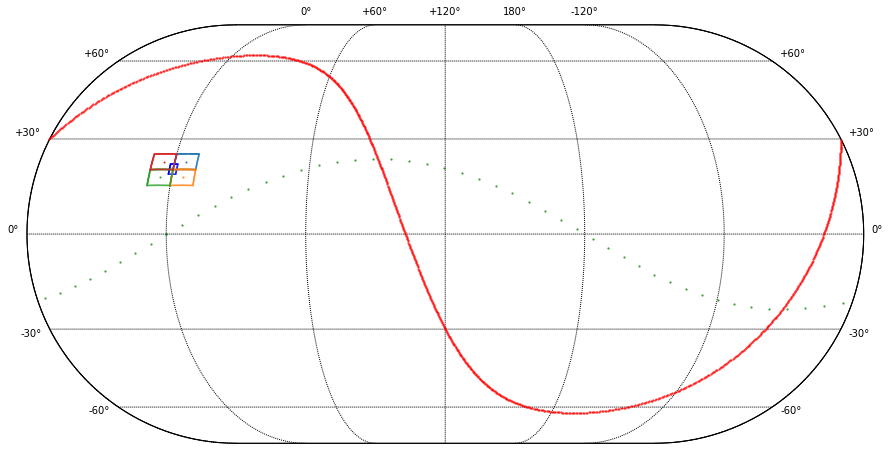

In [11]:
# Show our field on the sky, and highlight overlaping bricks of the sweep files

pl.figure(figsize=(15,10))
color_cycle = pl.rcParams['axes.prop_cycle']

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
    m = desiutil.plots.init_sky(ecliptic_color='g')
    dither_poly.draw(m)

    for sweep_poly,c in zip(sweep_polys,color_cycle):
        sweep_poly.draw(m,c=c['color'])

## Create an input target catalog from the sweeps

This uses `desitarget_cuts` to assign target classes to objects. It doesn't assign priorities etc.; that happens when the MTL is made in the next section.

We define a custom SV target bitmasks and patch `desitarget` to implement cuts that use those.

Patch in our own target mask to customize priorities etc.

In [12]:
import apcsv.patch
reload(apcsv.patch)
from apcsv.patch import patch_desitarget_bits

# Restores targetmask to default
reload(desitarget)
reload(desitarget.targetmask)
reload(desitarget.mtl)
reload(desitarget.targets)
reload(desitarget.cuts)

<module 'desitarget.cuts' from '/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py'>

In [13]:
# Check the existing definitions
for _ in mws_mask.names(): print(_)
mws_mask.names() == desitarget.targetmask.mws_mask.names()

MWS_BROAD
MWS_WD
MWS_NEARBY
MWS_BROAD_NORTH
MWS_BROAD_SOUTH
MWS_MAIN_BLUE
MWS_MAIN_BLUE_NORTH
MWS_MAIN_BLUE_SOUTH
MWS_MAIN_RED
MWS_MAIN_RED_NORTH
MWS_MAIN_RED_SOUTH


True

In [14]:
# Patch with our definitions
new_yaml = os.path.join(ROOT_DIR,'targetmasks/mws_sv_fix_targetmask.yaml')
desi_mask, bgs_mask, mws_mask, obsmask, obsconditions = patch_desitarget_bits(desitarget,
                                                                              new_yaml)
# Reload functions
import desitarget.mtl
reload(desitarget.mtl)

import desitarget.targets
reload(desitarget.targets)

import desitarget.cuts
reload(desitarget.cuts);

In [15]:
# Now patch desitarget cuts with our own cuts
import apcsv.cuts
reload(apcsv.cuts)

desitarget.cuts.isMWS_main_colors   = apcsv.cuts.isMWS_main_colors
desitarget.cuts.notinMWS_main_mask  = apcsv.cuts.notinMWS_main_mask

desitarget.cuts.isMWS_faint_colors  = apcsv.cuts.isMWS_faint_colors
desitarget.cuts.notinMWS_faint_mask = apcsv.cuts.notinMWS_faint_mask

desitarget.cuts.isMWS_main          = apcsv.cuts.isMWS_main

# Patch the target selection functions
desitarget.cuts.set_target_bits     = apcsv.cuts.set_target_bits

In [16]:
# Check these are what we want
for _ in mws_mask.names(): print(_)
mws_mask.names() == desitarget.targetmask.mws_mask.names()

MWS_BROAD
MWS_WD
MWS_NEARBY
MWS_BROAD_NORTH
MWS_BROAD_SOUTH
MWS_MAIN_BLUE
MWS_MAIN_BLUE_NORTH
MWS_MAIN_BLUE_SOUTH
MWS_MAIN_RED
MWS_MAIN_RED_NORTH
MWS_MAIN_RED_SOUTH


True

In [17]:
sweep_filenames = [os.path.basename(_) for _ in original_sweep_files]
sweep_index     = [sweep_filenames.index(os.path.basename(_)) for _ in sweeps_for_sv]

In [18]:
# This cell runs the select_targets function from desitarget.
# This is equivalent to running the select_sv_targets script.

# If true, regenerate targets
reset_target_input = False

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # This tries to set the mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger
log = get_logger()

print('Have {:d} sweeps as input'.format(len(sweep_index)))

dest = os.path.join(datadir,'sv_targets.fits')

# Which target classes to include
tcnames = _parse_tcnames('MWS,BGS,STD')
# tcnames = _parse_tcnames(tcstring=None, add_all=False)

if (not os.path.exists(dest)) or reset_target_input:
    sweep_input  = [original_sweep_files[_] for _ in sweep_index]
    srcdir       = os.path.dirname(sweep_filenames[0])
    qsoselection = 'colorcuts'
    nside        = io.desitarget_nside()
    survey       = 'main'
    
    # We trap a lot of floating point warnings
    print('Selecting targets...')
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        targets = desitarget.cuts.select_targets(sweep_input, 
                             numproc = 4,
                             qso_selection = qsoselection, 
                             tcnames = tcnames, 
                             survey  = survey)

        # Report warnings
        _us,_cs = np.unique([_.category for _ in w],return_counts=True)
        print('{} warnings from select_targets'.format(len(w)))
        for _u,_c in zip(_us,_cs):
            print("%15s %10d".format(_u,_c))

    io.write_targets(dest, targets, indir=srcdir, survey=survey,
                     qso_selection=qsoselection, nside=nside)
    print('Wrote targets to {}'.format(dest))
else:
    print('Targets already in {}'.format(dest))

Have 4 sweeps as input
Selecting targets...
INFO:cuts.py:2259:select_targets: Running on the main survey
INFO:cuts.py:778:isMWS_WD: 20346/2256203 NaNs in file...t = 47.7s


SlaveException: Unknown mask bit name MWS_MAIN_BLUE_FAINT
Traceback (most recent call last):
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/internal/sharedmem.py", line 265, in _slaveMain
    self.main(self, *self.args)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/internal/sharedmem.py", line 563, in _main
    r = realfunc(work)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/internal/sharedmem.py", line 629, in realfunc
    else: return func(i)
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py", line 2293, in _select_targets_file
    tcnames=tcnames, survey=survey
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py", line 2086, in apply_cuts
    Grr, primary
  File "/global/u1/a/apcooper/projects/mws_svplan/py/apcsv/cuts.py", line 570, in set_target_bits
    mws_target |= mws_blue_faint   * mws_mask.MWS_MAIN_BLUE_FAINT
  File "/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desiutil/master/py/desiutil/bitmask.py", line 257, in __getattr__
    raise AttributeError('Unknown mask bit name ' + name)
AttributeError: Unknown mask bit name MWS_MAIN_BLUE_FAINT


## Prepare MTL

Reads the target list prepared above and converts it to MTL input for fiberassign.

In [ ]:
targetdata = fitsio.read(local_targets_path)

In [109]:
# Compute MTL
reset_mtl = True
if not os.path.exists(mtl_path) or reset_mtl:
    
    if reset_mtl:
        if os.path.exists(mtl_path):
            os.remove(mtl_path)
        
    print('computing mtl')
    mtl = desitarget.mtl.make_mtl(targetdata)
    
    # only include MWS
    ismws = mtl['MWS_TARGET']!=0
    mtl   = mtl[ismws]

    mtl.meta['EXTNAME'] = 'MTL'
    
    mtl.write(mtl_path)
    print('Wrote {}'.format(mtl_path))

    # Print some stats
    print('MWS_TARGETS: {}'.format(np.count_nonzero(mtl['MWS_TARGET']!=0)))
    print('BGS_TARGETS: {}'.format(np.count_nonzero(mtl['BGS_TARGET']!=0)))
    print('DESI_TARGETS: {}'.format(np.count_nonzero(mtl['DESI_TARGET']!=0)))
    print('finished computing mtl')
else:
    mtl = fitsio.read(mtl_path)

computing mtl
INFO:mtl.py:87:make_mtl: 864 of 599600 targets have priority zero, setting N_obs=0.
Wrote /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/run/data/mtl.fits
MWS_TARGETS: 454339
BGS_TARGETS: 3921
DESI_TARGETS: 454339
finished computing mtl


In [110]:
mws_mask.names()

['MWS_BROAD',
 'MWS_WD',
 'MWS_NEARBY',
 'MWS_BROAD_NORTH',
 'MWS_BROAD_SOUTH',
 'MWS_MAIN_BLUE',
 'MWS_MAIN_BLUE_NORTH',
 'MWS_MAIN_BLUE_SOUTH',
 'MWS_MAIN_RED',
 'MWS_MAIN_RED_NORTH',
 'MWS_MAIN_RED_SOUTH',
 'MWS_MAIN_BLUE_FAINT',
 'MWS_MAIN_BLUE_FAINT_NORTH',
 'MWS_MAIN_BLUE_FAINT_SOUTH',
 'MWS_MAIN_RED_FAINT',
 'MWS_MAIN_RED_FAINT_NORTH',
 'MWS_MAIN_RED_FAINT_SOUTH']

In [111]:
mws_mask['MWS_MAIN_BLUE_FAINT_SOUTH'].obsconditions

'GRAY|DARK'

Some basic analysis of the MTL:

In [112]:
n= len(mtl)
kk = np.zeros(n, dtype='i4')

for mask, xxx_target in [
    (desi_mask, 'DESI_TARGET'),
    (mws_mask, 'MWS_TARGET'),
    (bgs_mask, 'BGS_TARGET') ]:
    for name in mask.names():
        #- which targets have this bit for this mask set?
        ii = (mtl[xxx_target] & mask[name]) != 0
        #- under what conditions can that bit be observed?
        if np.any(ii):
            _ = obsconditions.mask(mask[name].obsconditions)
            print(name, ii.sum(),_,
                  np.sum((kk[ii] > 0) & (kk[ii] != _)))
            kk[ii] |= obsconditions.mask(mask[name].obsconditions)

STD_FAINT 9256 3 0
STD_WD 470 7 0
STD_BRIGHT 4211 4 4211
BGS_ANY 3921 1 51
MWS_ANY 454339 1 9726
MWS_BROAD 49021 7 49018
MWS_WD 470 7 0
MWS_NEARBY 707 7 512
MWS_BROAD_NORTH 49021 7 0
MWS_BROAD_SOUTH 49021 7 0
MWS_MAIN_BLUE 43230 7 38882
MWS_MAIN_BLUE_NORTH 43230 7 0
MWS_MAIN_BLUE_SOUTH 43230 7 0
MWS_MAIN_RED 6834 7 6834
MWS_MAIN_RED_NORTH 6834 7 0
MWS_MAIN_RED_SOUTH 6834 7 0
MWS_MAIN_BLUE_FAINT 135746 3 135746
MWS_MAIN_BLUE_FAINT_NORTH 135746 3 304
MWS_MAIN_BLUE_FAINT_SOUTH 135746 3 304
MWS_MAIN_RED_FAINT 219058 3 219058
MWS_MAIN_RED_FAINT_NORTH 219058 3 88
MWS_MAIN_RED_FAINT_SOUTH 219058 3 88
BGS_FAINT 124 7 124
BGS_BRIGHT 110 4 110
BGS_WISE 3687 4 3687
BGS_FAINT_NORTH 124 7 0
BGS_BRIGHT_NORTH 110 4 110
BGS_WISE_NORTH 3687 4 3687
BGS_FAINT_SOUTH 124 7 0
BGS_BRIGHT_SOUTH 110 4 110
BGS_WISE_SOUTH 3687 4 3687


In [113]:
np.unique(kk)

array([3, 7], dtype=int32)

In [115]:
obsconditions.names(3)

['DARK', 'GRAY']

In [116]:
mtl[0:2]

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,HPXPIXEL,NUMOBS_MORE,PRIORITY,OBSCONDITIONS
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,bytes1,int64,int64,int64,int64,float64,int64,int32,int64,int32
7000,309476,1758m037,17,PSF,175.746271327,-3.87414409213,4.79072e+11,5.16176e+11,17184.5 .. 0.0,0.0242219,2.39132,4.52241,6.31422,1.93724,0.183091,6.59739,418.952,921.345,337.171,126.254,2.68729,0.495305,0.000844025,1.99513e-05,0.930808,0.952848,0.973345,0.995903,0.997482,0.999462,0.999797,3,3,4,0.00133273,0.00734054,0.00836629,0.0128835,0.0328306,0.0190553,0.999617,0.999306,0.997198,0,0,0,1413.67,463.854,136.339,802.651,298.765,73.2055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.85754,3.51294,4.90479,1.85754,3.51294,4.90479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,False,S,30787623614152721,2305843009213693952,0,114688,0.906783787488,25579,1,1550,3
7000,309476,1758m037,21,PSF,175.978796686,-3.874213462,4.78233e+13,1.97441e+14,96735.3 .. 0.0,0.0264122,13.0541,16.1182,16.6104,3.72774,1.48958,31.9068,-314.908,234.98,140.523,73.1918,2.76127,0.500136,0.00106286,2.26842e-05,0.924793,0.948696,0.97097,0.995534,0.997255,0.999414,0.999779,2,2,3,3.39329e-05,7.27919e-05,0.000223807,0.0184273,0.0152542,0.0302612,0.998661,0.997917,0.993947,0,0,0,871.04,348.148,89.129,467.553,200.569,46.0888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1583,12.5427,12.9257,10.1583,12.5427,12.9257,3600042240342830848,19.5505,251.736,19.766,15.6556,19.1888,16.6083,0.0,False,0.302915,2.90108,-3.79489,1.08388,-0.55962,4.44368,False,S,30787623614152725,2305843009213693952,0,114688,0.0775133739913,25579,1,1550,3


In [117]:
# List all the combinations of MWS mask bits and the Tractor types assocated with those bits.
for mwst in np.unique(mtl['MWS_TARGET']):
    w = np.flatnonzero(mtl['MWS_TARGET'] == mwst)
    print(mws_mask.names(mwst))
    print('   ', [_.strip() for _ in (np.unique(mtl['MORPHTYPE'][w]))])

['MWS_WD']
    ['COMP', 'PSF']
['MWS_NEARBY']
    ['COMP', 'PSF', 'REX']
['MWS_WD', 'MWS_NEARBY']
    ['EXP', 'PSF']
['MWS_BROAD', 'MWS_BROAD_NORTH', 'MWS_BROAD_SOUTH']
    ['PSF']
['MWS_BROAD', 'MWS_NEARBY', 'MWS_BROAD_NORTH', 'MWS_BROAD_SOUTH']
    ['PSF']
['MWS_BROAD', 'MWS_WD', 'MWS_NEARBY', 'MWS_BROAD_NORTH', 'MWS_BROAD_SOUTH']
    ['PSF']
['MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_WD', 'MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_NEARBY', 'MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_WD', 'MWS_NEARBY', 'MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_MAIN_RED', 'MWS_MAIN_RED_NORTH', 'MWS_MAIN_RED_SOUTH']
    ['PSF']
['MWS_MAIN_BLUE_FAINT', 'MWS_MAIN_BLUE_FAINT_NORTH', 'MWS_MAIN_BLUE_FAINT_SOUTH']
    ['PSF']
['MWS_WD', 'MWS_MAIN_BLUE_FAINT', 'MWS_MAIN_BLUE_FAINT_NORTH', 'MWS_MAIN_BLUE_FAINT_SOUTH']
    ['PSF']
['MWS_WD', 'MWS_NEARBY', 'MWS_

In [118]:
mtl.colnames

['RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FRACDEV',
 'FRACDEV_IVAR',
 'SHAPEDEV_R',
 'SHAPEDEV_R_IVAR',
 'SHAPEDEV_E1',
 'SHAPEDEV_E1_IVAR',
 'SHAPEDEV_E2',
 'SHAPEDEV_E2_IVAR',
 'SHAPEEXP_R',
 'SHAPEEXP_R_IVAR',
 'SHAPEEXP_E1',
 'SHAPEEXP_E1_IVAR',
 'SHAPEE

In [119]:
np.unique(mtl['PRIORITY'])

1400
1500
1540
1550
1600
2000
2100
2998


In [120]:
print('{:15s} {:>17s} {:>17s} {:>8s} {:>8s}'.format('PROPERTY','MIN','MAX','NEGATIVE','ZERO'))
for p in ['FLUX_G','FLUX_R','FLUX_IVAR_G','FLUX_IVAR_R','RA','DEC','PRIORITY']:
    print('{:15s} {:17.3f} {:17.3f} {:8d} {:8d}'.format(p,
                                                        mtl[p].min(),
                                                        mtl[p].max(),
                                                        (mtl[p] < 0).sum(),
                                                        (mtl[p] == 0).sum(),
                                                        ))

PROPERTY                      MIN               MAX NEGATIVE     ZERO
FLUX_G                 -25260.414        159124.281        3        3
FLUX_R                 -72780.258       1836300.250        3        2
FLUX_IVAR_G                 0.000         12903.959        0        3
FLUX_IVAR_R                 0.000          1931.864        0        2
RA                        170.000           180.000        0        0
DEC                        -5.000             5.000   237689        0
PRIORITY                 1400.000          2998.000        0        0


WARNING         COUNT
RuntimeWarning  5


(23, 8)

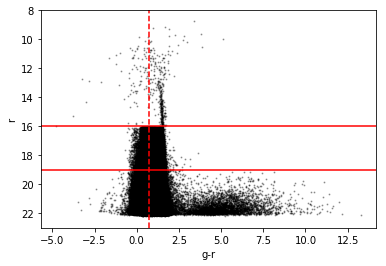

In [121]:
# Colour-magnitude plot

with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(mtl['FLUX_G'])+22.5
    r = -2.5*np.log10(mtl['FLUX_R'])+22.5
    pl.scatter(g-r,r,s=1,alpha=0.3,c='k')
warning_summary(W)

pl.xlabel('g-r')
pl.ylabel('r')
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)

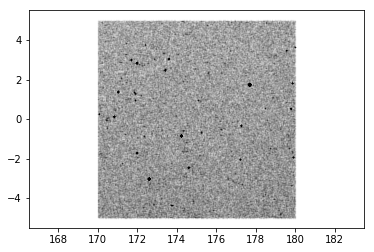

In [122]:
# Sky plot
pl.scatter(mtl['RA'],mtl['DEC'],c='k',s=1,alpha=0.01)
pl.axis('equal');

## Prepare standard stars

In [123]:
# Standards
reset_standards = True

if not os.path.exists(std_path) or reset_standards:
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
                 'STD_FAINT', 'STD_FAINT_BEST',
                 'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    is_std  = (targetdata['DESI_TARGET'] & std_mask) != 0
    stddata = targetdata[is_std]

    obscond = np.int_(np.repeat(obsconditions['BRIGHT'], len(stddata)))
    stddata = np.lib.recfunctions.append_fields(stddata, 'OBSCONDITIONS', obscond)  
        
    fitsio.write(std_path, stddata, extname='STD',clobber=True)
    print('{} standards'.format(np.count_nonzero(stddata)))
    print('Wrote standards to {}'.format(std_path))
    print('Finished with standards')
else:
    print('Reading existing standards: {}'.format(std_path))
    stddata = fitsio.read(std_path,extname='STD')

10590 standards
Wrote standards to /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/run/data/std.fits
Finished with standards


## Run fiberassign

In [124]:
# Show fiberassign options
!fiberassign -h

usage: fiberassign [-h] --mtl MTL --sky SKY [--stdstar STDSTAR]
                   [--fibstatusfile FIBSTATUSFILE] [--footprint FOOTPRINT]
                   [--positioners POSITIONERS] [--surveytiles SURVEYTILES]
                   [--telra TELRA] [--teldec TELDEC] [--tileid TILEID]
                   [--tileobsconditions TILEOBSCONDITIONS] [--outdir OUTDIR]
                   [--starmask STARMASK] [--rundate RUNDATE]
                   [--gfafile GFAFILE] [--nstarpetal NSTARPETAL]
                   [--nskypetal NSKYPETAL] [--nocleanup] [--version]

optional arguments:
  -h, --help            show this help message and exit
  --mtl MTL             input targets (FITS file)
  --sky SKY             input sky positions (FITS file)
  --stdstar STDSTAR     input std stars (FITS file)
  --fibstatusfile FIBSTATUSFILE
                        list of positioners and its status (ECSV or txt file)
  --footprint FOOTPRINT
                        list of tiles defining the footprint (FITS file)
 

Run fiberassign.

In [125]:
STANDARDS_PER_PETAL  = 20
SKYS_PER_PETAL       = 80

for f in glob.glob(os.path.join(outdir,'*.fits')):
    print('Removing {}'.format(f))
    os.remove(f)

cmd = "fiberassign --mtl {} ".format(mtl_path)
cmd += " --sky {} ".format(sky_path)
cmd += " --stdstar {} ".format(std_path)
# cmd += " --fibstatusfile ./fiberstatus.ecsv"
cmd += " --footprint {}".format(tile_path)
cmd += " --gfafile {}".format(gfa_path)
cmd += " --outdir {} ".format(outdir)
cmd += " --nstarpetal {:d} ".format(STANDARDS_PER_PETAL)
cmd += " --nskypetal {:d}".format(SKYS_PER_PETAL)

print(cmd)
print('starting fiberassign')
ecode = os.system(cmd)
print('finished fiberassign: {}'.format(ecode))

Removing /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/run/output/tile_00000.fits
fiberassign --mtl /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/run/data/mtl.fits  --sky /project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/skies-dr7.1-0.22.0.fits  --stdstar /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/run/data/std.fits  --footprint /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/tiles/mws_sv_tiles.fits --gfafile /project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/gfas-dr7.1.fits --outdir /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile/run/output  --nstarpetal 20  --nskypetal 80
starting fiberassign
finished fiberassign: 0


In [126]:
!ls $outdir

tile_00000.fits
